In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import ast
import unicodedata
import seaborn as sns
import warnings
from openai import OpenAI
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


# 3 Analytics and Learning Strategies

## a) A first BERT approach for sentiment analysis

## b) Leveraging LLMs with OpenAI

In [10]:
ecb_press = pd.read_parquet('../data/ecb_press.parquet')

### GPT4o-mini has a context length of 128 000 tokens, we need to restrict the articles selected with a limited number of characters to be sure we will be able to work with them

Nombre d'articles retirés après premier filtre : 112


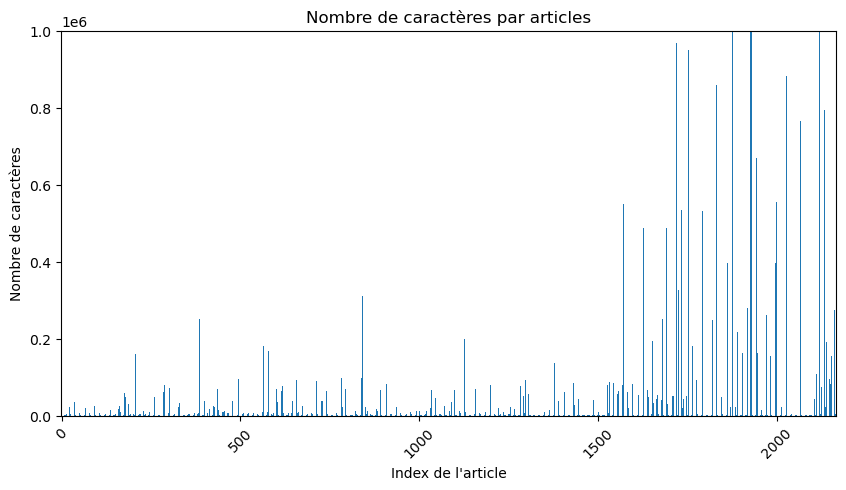

In [14]:
ecb_press['content'].str.len().plot(kind='bar',
                                    xticks=np.arange(0, ecb_press.shape[0],500),
                                    title="Nombre de caractères par articles",
                                    ylim=(0, 1e6), 
                                    figsize=(10,5),
                                    xlabel="Index de l'article", ylabel='Nombre de caractères')

plt.xticks(rotation=45)

ecb_press_filtered = ecb_press.loc[ecb_press.content.str.len()<= 250000].reset_index(drop=True).copy()
print("Nombre d'articles retirés après premier filtre :", ecb_press.shape[0] - ecb_press_filtered.shape[0])

### Here we explain our strategy:

Following the failure of BERT, we decided to leverage all the data at our disposal to extract as much valuable information as possible. Two natural approaches presented themselves:

1. **Using open-source LLMs (e.g., Hugging Face models)**: For example, employing Llama-3 with a context size similar to GPT-4 mini would allow us to perform the tasks at no cost. The issue? It would require substantial inference resources due to the massive size of these models (over 1 billion parameters).

Note: We attempted this approach, but it was impossible to implement, even with a GPU available.

2. **Using hosted LLMs**: This avoids the inference challenges and allows us to take advantage of the state-of-the-art models currently available in the market (e.g., Claude, ChatGPT).

We decided to go with the second option and allocated $5 on OpenAI to maximize the utility of our database.

In [15]:
def nettoyer_texte(texte):
    if pd.isnull(texte):
        return texte
    texte = re.sub(r'[\n\t\r]+', ' ', texte)
    texte = re.sub(r'\s{2,}', ' ', texte)
    texte = re.sub(r'[^\w\s.,;:!?\'"-]', '', texte)
    texte = texte.strip()
    texte = texte.lower()
    return texte

print('Nombre de caractères totaux avant nettoyage :', ecb_press_filtered.content.str.len().sum())
ecb_press_filtered['content'] = ecb_press_filtered['content'].apply(lambda x: nettoyer_texte(x))
print('Nombre de caractères totaux après nettoyage :', ecb_press_filtered.content.str.len().sum())

Nombre de caractères totaux avant nettoyage : 50853943
Nombre de caractères totaux après nettoyage : 50166920


### We use the following prompt to leverage sentiment analysis on the overall markets and on the key sectors mentioned previously. Our goal is to study whether we can extract insightful information from this corpus.

In [16]:
prompt = """You will analyze the given article text, sourced from the European Central Bank's (ECB) website. The goal is to extract structured data reflecting its relevance to European financial markets and to assess both the overall European market sentiment and sector-specific sentiment. The results must be output in a strict JSON format with the following fields:

1. Overall European market sentiment of the article:
   - global_sentiment:
     - score: A value between 0 and 1, where 0 = very negative, 0.5 = neutral, and 1 = very positive.
     - category: A string that can be "Negative", "Neutral", or "Positive" based on the score.

2. Overall market relevance (European context):
   - market_relevance_score: A value between 0 and 1 indicating how relevant the article is to European financial markets, where 0 = no relevance and 1 = very high relevance.

3. Sector analysis (European market sectors):
   Provide a list or array of objects, each representing one of the following European market sectors: "Banks", "Oil & Gas", "Technology", "Healthcare", and "Utilities". For each sector:
     - name: The sector name.
     - sentiment_score: A value between 0 and 1 indicating the sentiment towards that sector.
     - relevance_score: Must be one of the following values only: 0, 0.5, or 1, indicating the sector's relevance in the European context.

4. Key points and keywords:
   - key_points: A list of bullet-pointed key messages, facts, or insights from the article that could influence European financial markets.
   - keywords: A list of major themes or terms extracted from the article.

Instructions:
- Read the article text provided after these instructions.
- Analyze it according to the criteria above.
- Return the results strictly as a JSON object with the fields described, and no additional commentary outside of that JSON.

Use exactly this template format:
{
    "overall_european_market_sentiment": {
        "global_sentiment": {
            "score": 0.7,
            "category": "Positive"
        }
    },
    "overall_market_relevance": {
        "market_relevance_score": 1
    },
    "sector_analysis": [
        {
            "name": "Banks",
            "sentiment_score": 0.6,
            "relevance_score": 1
        },
        {
            "name": "Oil & Gas",
            "sentiment_score": 0,
            "relevance_score": 0
        },
        {
            "name": "Technology",
            "sentiment_score": 0.8,
            "relevance_score": 1
        },
        {
            "name": "Healthcare",
            "sentiment_score": 0,
            "relevance_score": 0
        },
        {
            "name": "Utilities",
            "sentiment_score": 0,
            "relevance_score": 0
        }
    ],
    "key_points": [
        "Point 1",
        "Point 2",
        "Point 3",
        "Point 4",
        "Point 5"
    ],
    "keywords": [
        "keyword1",
        "keyword2",
        "keyword3",
        "keyword4",
        "keyword5"
    ]
}"""

## WARNING - For launching this cell you need to provide your own API-KEY from OpenAI

In [ ]:
from pandas import json_normalize
import json
from tqdm import trange, tqdm

api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)



def texte_analyse_gpt4(prompt, texte, temperature):
    
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            
            {
            "role": "system",
            "content": prompt
            },
            
            {
            "role": "user",
            "content": texte
            }
        ],
        temperature=temperature
    )
    
    return completion.choices[0].message.content

def nettoyer_json(chaine):
    
    chaine = chaine.strip()
    if chaine.startswith('```json'):
        chaine = chaine[len('```json'):].lstrip('\n')
    if chaine.endswith('```'):
        chaine = chaine[:-len('```')].rstrip()
        
    return chaine

def dataframe_json(json_data):
    try:

        data = json.loads(json_data)
        
        flattened_data = {}
        
        flattened_data['global_sentiment_score'] = data['overall_european_market_sentiment']['global_sentiment']['score']
        flattened_data['global_sentiment_category'] = data['overall_european_market_sentiment']['global_sentiment']['category']
        flattened_data['market_relevance_score'] = data['overall_market_relevance']['market_relevance_score']
        
        sectors = {sector['name']: sector for sector in data['sector_analysis']}
        for sector_name in ["Banks", "Oil & Gas", "Technology", "Healthcare", "Utilities"]:
            sector = sectors.get(sector_name, {})
            flattened_data[f'{sector_name}_sentiment_score'] = sector.get('sentiment_score', 0)
            flattened_data[f'{sector_name}_relevance_score'] = sector.get('relevance_score', 0)
        
        flattened_data['key_points'] = ' | '.join(data['key_points'])
        flattened_data['keywords'] = ' | '.join(data['keywords'])
        
        return pd.DataFrame([flattened_data])
    
    except json.JSONDecodeError as e:
        print(f"Erreur lors du parsing du JSON : {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Erreur inattendue : {e}")
        return pd.DataFrame()


def recolter_sentiment(prompt, temperature, ecb_press_df):
    
    df = pd.DataFrame()
            
    for i in trange(ecb_press_df.shape[0]):
        
        texte = ecb_press_df['content'].iloc[i]
        output = texte_analyse_gpt4(prompt=prompt, texte=texte, temperature=0)
        output = nettoyer_json(output)
        df_json = dataframe_json(output)
        
        df =pd.concat([df, df_json], axis=0)
        df.to_csv(f'ecb_sentiment_article.csv')
        
    df = df.reset_index(drop=True)   
    df_final = pd.concat([ecb_press_df, df], axis=1)
    
    return df_final
    
ecb_sentiment = recolter_sentiment(prompt=prompt,
                                   temperature=0,
                                   ecb_press_df=ecb_press_filtered)

In [20]:
ecb_sentiment_ = pd.read_csv('../data/ecb_sentiment_article.csv', index_col=0).reset_index(drop=True)
glob = pd.concat([ecb_press_filtered, ecb_sentiment_], axis=1)
glob = glob.set_index('date')
glob['year'] = glob.index.year
glob.head(2)


,language,url,content,title_2,global_sentiment_score,global_sentiment_category,market_relevance_score,Banks_sentiment_score,Banks_relevance_score,Oil & Gas_sentiment_score,Oil & Gas_relevance_score,Technology_sentiment_score,Technology_relevance_score,Healthcare_sentiment_score,Healthcare_relevance_score,Utilities_sentiment_score,Utilities_relevance_score,key_points,keywords,year
date,,,,,,,,,,,,,,,,,,,,
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,feedback on fit in the ecosystem consultation ...,PDF Title,0.6,Positive,1.0,0.5,1.0,0.0,0.0,0.7,1.0,0.0,0.0,0.0,0.0,Digital euro will increase competition in the ...,digital euro | payment sector | competition | ...,2024
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,ecb-public preliminary methodology for calibra...,PDF Title,0.6,Positive,1.0,0.7,1.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,ECB is developing a methodology for setting di...,digital euro | holding limits | monetary polic...,2024


<Axes: title={'center': 'Distribution des sentiments récupérés par ChatGPT'}, ylabel='Catégories des Sentiments'>

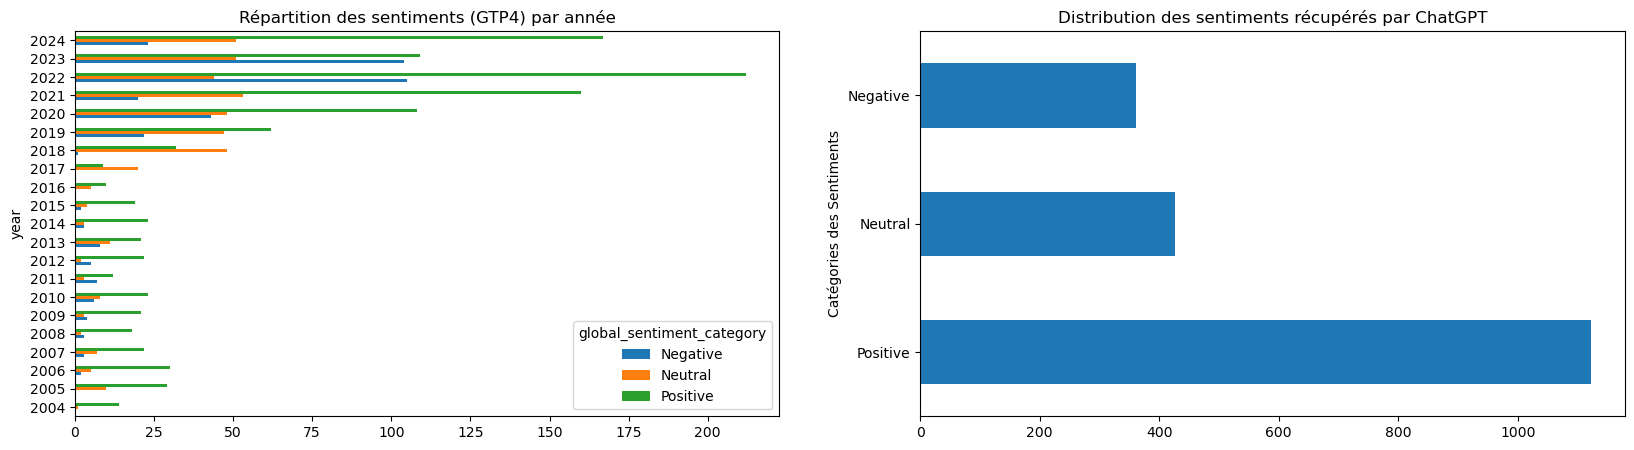

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))

glob.dropna(subset=['global_sentiment_category']) \
         .groupby('year')['global_sentiment_category'] \
         .value_counts() \
         .unstack() \
         .fillna(0) \
         .plot(kind='barh', ax=ax[0], title='Répartition des sentiments (GTP4) par année')
         
glob['global_sentiment_category'] \
        .value_counts() \
        .plot(kind='barh', title='Distribution des sentiments récupérés par ChatGPT', ylabel='Catégories des Sentiments', ax=ax[1])

In [22]:
print("Nombre d'articles non liés aux marchés:", glob[glob['market_relevance_score']==0].shape[0])
glob_ = glob.query('market_relevance_score > 0.5').copy()
glob_sent = glob_.groupby('date')['global_sentiment_score'].mean()

Nombre d'articles non liés aux marchés: 10


In [24]:
tickers = {
    "EURO STOXX 50": "^STOXX50E",
    "Banks": "EXH1.DE",
    "Oil & Gas": "EXH2.DE",
    "Technology": "EXH4.DE",
    "Healthcare": "EXH3.DE",
    "Utilities": "EXH5.DE"
}


data = yf.download(list(tickers.values()), start="2007-01-01")['Close']

[*********************100%***********************]  6 of 6 completed


In [28]:
euro_stoxx_50 = data[['^STOXX50E']]

In [29]:
es50_sent = euro_stoxx_50.merge(glob_sent, left_index=True, right_index=True, how='left').query('index >= 2018')

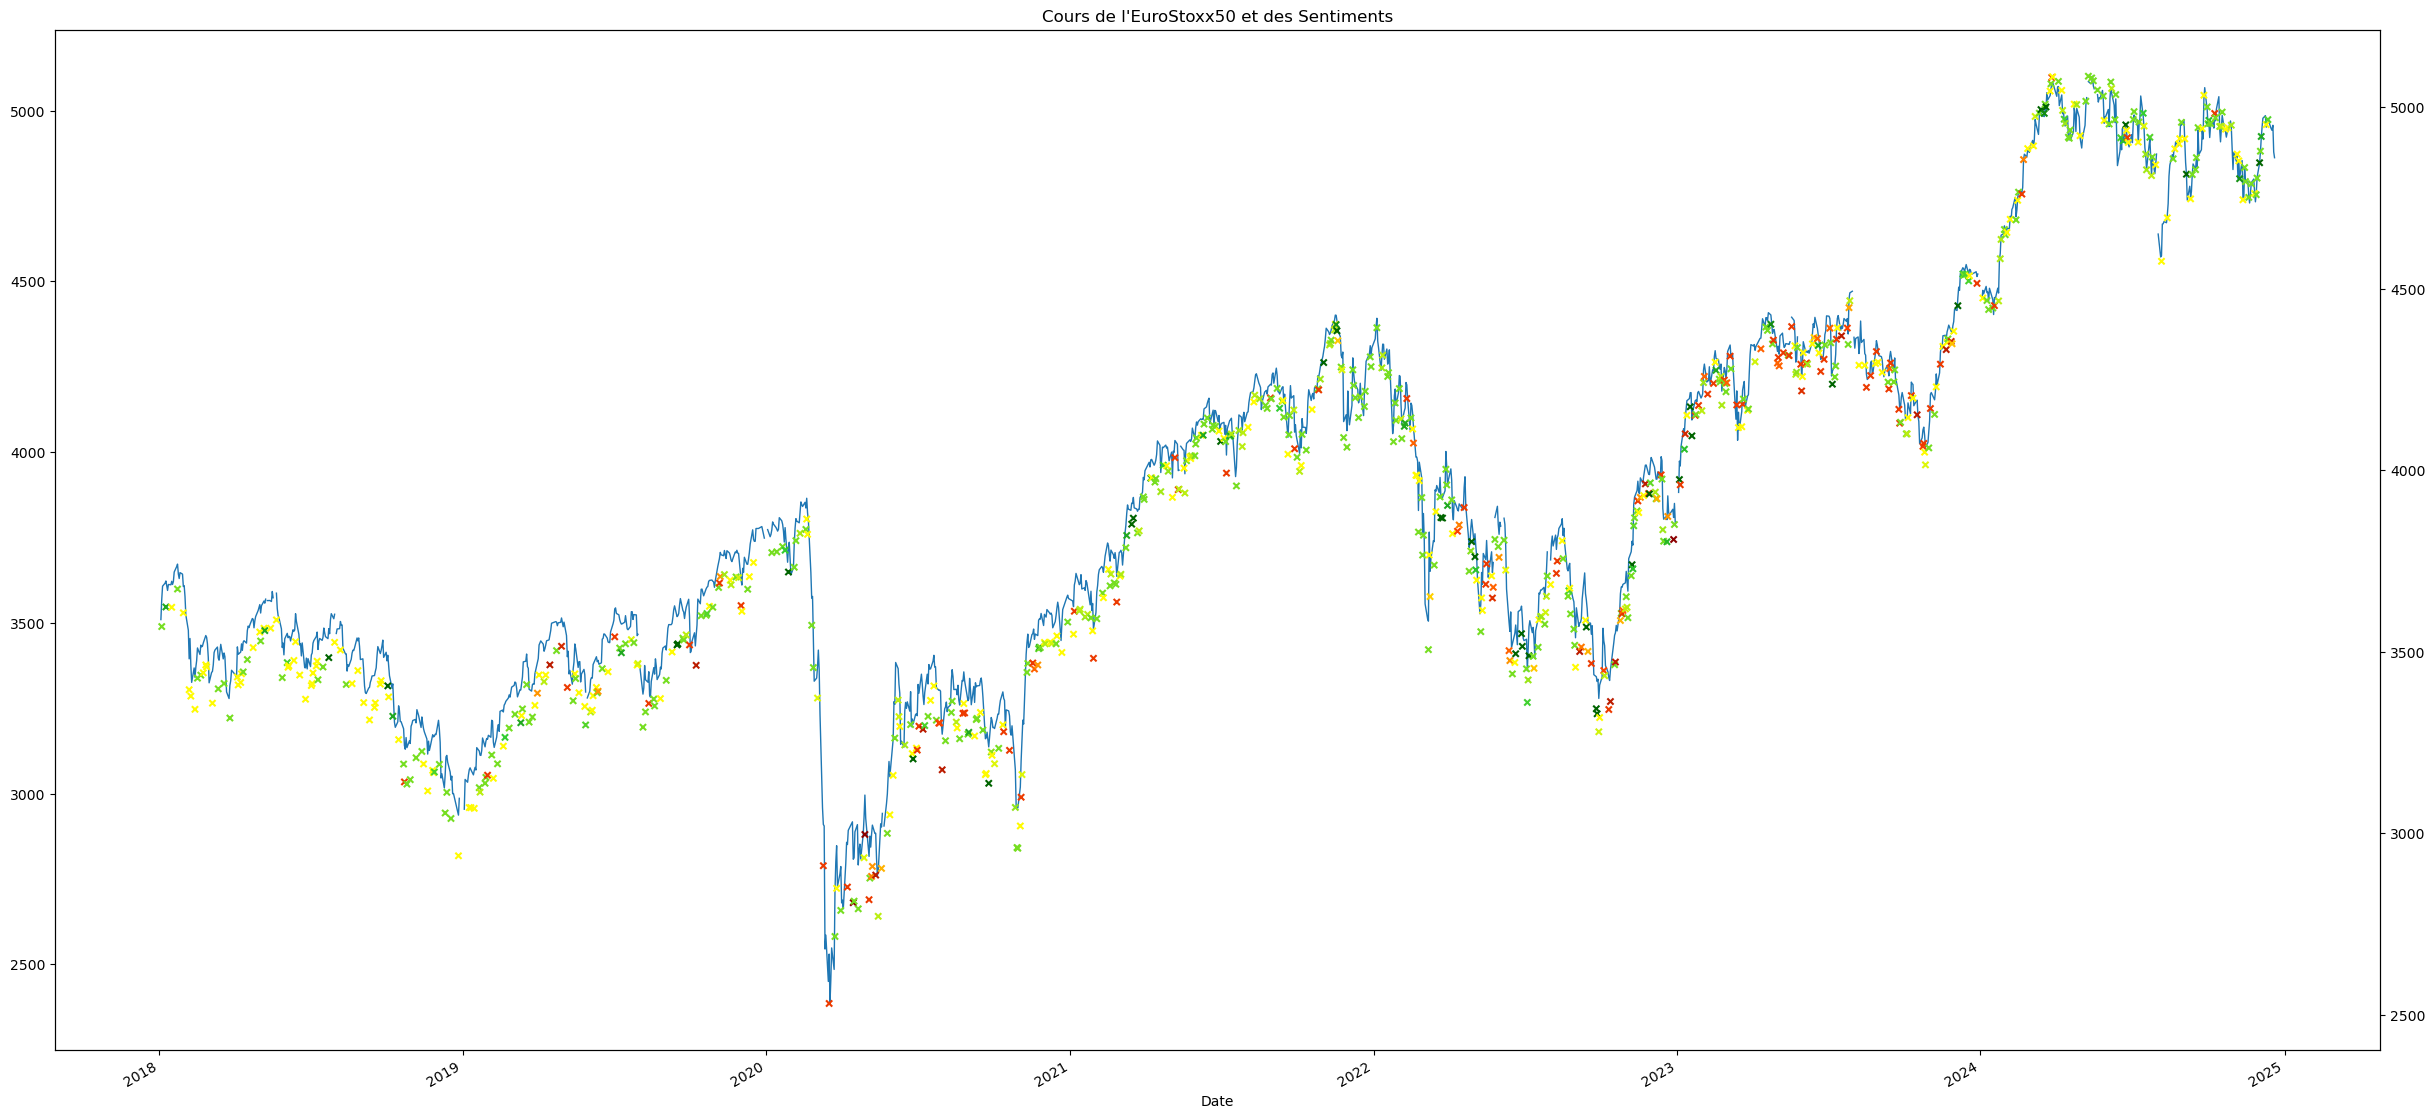

In [30]:
cmap_custom = mcolors.LinearSegmentedColormap.from_list(
    "CustomColormap",
    [
        (0, "#8B0000"),  # Rouge très foncé pour les faibles valeurs (0)
        (0.4, "#FF4500"),  # Rouge intense pour 0.4
        (0.5, "#FFFF00"),  # Jaune pour 0.5
        (0.75, "#32CD32"),  # Vert clair pour les valeurs proches de 0.75
        (1, "#006400"),  # Vert foncé pour 1
    ]
)


fig, ax = plt.subplots(figsize=(30, 15))
ax2 = ax.twinx()

es50_sent.query('index > 2018')['^STOXX50E'].plot(ax=ax, linewidth = 1, title="Cours de l'EuroStoxx50 et des Sentiments")
scatter = ax2.scatter(
    es50_sent.query('index > 2018').index,
    es50_sent.query('index > 2018')['^STOXX50E'],
    c=es50_sent.query('index > 2018')['global_sentiment_score'],
    cmap=cmap_custom,
    s=20,
    marker='x'
)

